In [90]:
#----------------------------------------------------
# Initial notebook for making the Illustris cosmic graph from galaxy catalogues
# Author: Christian Kragh Jespersen
# First created: 11/03/23 @KITP
# note: to make into routine later
#----------------------------------------------------

import h5py
import illustris_python as il
from torch_geometric.data import Data
from torch_geometric.loader import  DataLoader
import scipy.spatial as ss
import os, sys, torch, pickle, random, time
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [91]:
sys.path.insert(1, '../src')
from make_cosmic_web import *

In [92]:
reload = False #force a reload of the data to change cuts, use_loops, periodic or use_loops

## get illustris positions
tng_base_path = osp.expanduser("~/../../scratch/gpfs/cj1223/TNG50")
snapshot = 99
h = 0.7 # cosmology h, set to 1 if you want comoving Mpc

r_link = 4 #Mpc

cuts = {"minimum_log_stellar_mass": 9,
        "minimum_log_halo_mass": 8,
       "minimum_n_star_particles": 100}

undirected = True
periodic = False
use_loops = False

use_gal = True # True = use galaxy params to infer dark matter, False = use DM params to infer galaxy stuff

pad = 1 # how much padding to add around each subbox, so the separation in total will be 2 times this

split = 8 #how many subboxes

data_path = osp.join(tng_base_path, 'cosmic_graphs', f'split_{split}_link_{int(r_link)}_pad{int(pad)}_gal{int(use_gal)}.pkl')

if osp.isfile(data_path) and not reload:
    print('File already exists')
else:
    print('Remaking dataset')
    make_webs(tng_base_path = tng_base_path, snapshot = snapshot, r_link = r_link, pad = pad,\
              cuts = cuts, use_gal = use_gal, h = h, undirected = undirected, periodic = periodic,\
              use_loops = use_loops)
    
data = pickle.load(open(data_path, 'rb'))

File already exists


In [93]:
data

[Data(x=[136, 8], edge_index=[2, 1440], edge_attr=[1440, 3], y=[136, 2]),
 Data(x=[187, 8], edge_index=[2, 2354], edge_attr=[2354, 3], y=[187, 2]),
 Data(x=[185, 8], edge_index=[2, 2560], edge_attr=[2560, 3], y=[185, 2]),
 Data(x=[438, 8], edge_index=[2, 23388], edge_attr=[23388, 3], y=[438, 2]),
 Data(x=[411, 8], edge_index=[2, 17430], edge_attr=[17430, 3], y=[411, 2]),
 Data(x=[225, 8], edge_index=[2, 3320], edge_attr=[3320, 3], y=[225, 2]),
 Data(x=[264, 8], edge_index=[2, 3520], edge_attr=[3520, 3], y=[264, 2]),
 Data(x=[154, 8], edge_index=[2, 1618], edge_attr=[1618, 3], y=[154, 2])]

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    MessagePassing, SAGEConv, GCNConv, PPFConv, MetaLayer, EdgeConv,
    global_mean_pool, global_max_pool, global_add_pool )

In [95]:
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm, LeakyReLU, Module, ReLU, Sequential, ModuleList
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool, MetaLayer
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_add
from torch import cat, square,zeros, clone, abs, sigmoid, float32, tanh, clamp

class MLP(Module):
    def __init__(self, n_in, n_out, hidden=64, nlayers=2, layer_norm=True):
        super().__init__()
        '''Simple MLP class with ReLU activiation + layernorm'''
        layers = [Linear(n_in, hidden), ReLU()]
        for i in range(nlayers):
            layers.append(Linear(hidden, hidden))
            layers.append(ReLU()) 
        if layer_norm:
            layers.append(LayerNorm(hidden))
        layers.append(Linear(hidden, n_out))
        self.mlp = Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class Sage(Module):
    def __init__(self, hidden_channels, in_channels, out_channels, encode=True, conv_layers=3, conv_activation='relu', 
                    decode_layers=2, decode_activation='leakyrelu', layernorm=True, variance=1, agg='sum'):
        super(Sage, self).__init__()
        '''Model built upon the GraphSAGE convolutional layer. This is a node only model (no global, no edge).
        Model takes a data object from a dataloader in the forward call and takes out the rest itself. 
        hidden_channels, n_in, n_out must be specified
        Most other things can be customized at wish, e.g. activation functions for which ReLU and LeakyReLU can be used'''
        self.encode=encode
        if self.encode:
            self.node_enc = MLP(in_channels, hidden_channels, layer_norm=True) #could turn up hidden states
        self.decode_activation=decode_activation
        self.conv_activation=conv_activation
        self.layernorm=layernorm
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.hidden_channels=hidden_channels
        self.variance=variance
        self.agg=agg
        
        ########################
        # Convolutional Layers #
        ######################## 

        self.convs=ModuleList()
        if self.encode:
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        else:
            self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(int(conv_layers-1)):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        ##################
        # Decode Layers #
        ##################       

        self.decoders = ModuleList()
        self.norms = ModuleList()
        for _ in range(out_channels):
            self.decoder=ModuleList()
            self.norm=ModuleList()
            for i in range(decode_layers):
                if i==decode_layers-1: ## if final layer, make layer with only one output
                    self.decoder.append(Linear(hidden_channels, 1))
                    self.norm.append(LayerNorm(normalized_shape=0)) ## redundant layer, throws an error on purpose if used
                    
                else:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, hidden_channels))
            self.decoders.append(self.decoder)
            self.norms.append(self.norm)

        ###################
        # Variance Layers #
        ###################

        if variance:
            self.sigs = ModuleList()
            self.sig_norms = ModuleList()
            for _ in range(out_channels):
                self.sig=ModuleList()
                self.sig_norm=ModuleList()
                for i in range(decode_layers):
                    if i==decode_layers-1:
                        self.sig.append(Linear(hidden_channels, 1))
                        self.sig_norm.append(LayerNorm(normalized_shape=0)) ## redundant layer, throws an error on purpose if used
                    else:
                        self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.sig.append(Linear(hidden_channels, hidden_channels))
                self.sigs.append(self.sig)
                self.sig_norms.append(self.sig_norm)
        
        #####################
        # Activation Layers #
        #####################
        
        self.conv_act=self.conv_act_f()
        self.decode_act=self.decode_act_f() ## could apply later

    def conv_act_f(self):
        if self.conv_activation =='relu':
            print('RelU conv activation')
            act = ReLU()
            return act
        if self.conv_activation =='leakyrelu':
            print('LeakyRelU conv activation')
            act=LeakyReLU()
            return act
        if not self.conv_activation:
            raise ValueError("Please specify a conv activation function")

    def decode_act_f(self):
        if self.decode_activation =='relu':
            print('RelU decode activation')
            act = ReLU()
            return act
        if self.decode_activation =='leakyrelu':
            print('LeakyRelU decode activation')
            act=LeakyReLU()
            return act
        if not self.decode_activation:
            print("Please specify a decode activation function")
            return None

    def forward(self, graph):

        #get the data
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch
        #encode
        if self.encode:
            x = self.node_enc(x)
        
        #convolutions 
        for conv in self.convs:
            x = conv(x, edge_index)
            x=self.conv_act(x) ##choose whichever
        
        #decoder
        x_out=[]
        for norm, decode in zip(self.norms, self.decoders):
            x1=clone(x)
            for i, (n, d) in enumerate(zip(norm, decode)):
                if i != len(norm) - 1:

                    x1=n(d(x1))
                    x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
                else:
                    x1 = d(x1)
            x_out.append(x1)
        x_out=cat(x_out, dim=1)
        
        # variance
        if self.variance:
            sig=[]
            for norm, decode in zip(self.sig_norms, self.sigs):
                
            
                x1=clone(x)
                for i, (n, d) in enumerate(zip(norm, decode)):
                    if i != len(norm) - 1:

                        x1=n(d(x1))
                        x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
                    else:
                        x1 = d(x1)
                sig.append(x1)
            sig=abs(cat(sig, dim=1)) #stability

            return x_out, sig
        else:
            return x_out

In [96]:
n_feat, n_targ = len(data[0].x[0]), len(data[0].y[0])
model = Sage(64, n_feat, n_targ, variance = 0)

RelU conv activation
LeakyRelU decode activation


In [117]:
batch_size = 32
train_loader = DataLoader(data[1:], batch_size=batch_size, shuffle=1)
test_loader = DataLoader(data[:1], batch_size=batch_size, shuffle=0)

from scipy.spatial.transform import Rotation
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device
    
torch.manual_seed(42)
random.seed(42)

In [118]:
l1_lambda = 0
l2_lambda = 0

trains, tests, scatter = [], [], []
yss, preds=[],[]

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
if torch.cuda.is_available():
    _, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)

# Initialize our train function
datas = []
def train():
    global out
    model.train()
    for data in train_loader:  
        datas.append(data)
        out = model(data)  
        loss = criterion(out, data.y.view(-1,n_targ)) 
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
        
        if torch.cuda.is_available(): 
            accelerator.backward(loss)
        else:
            loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []

    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out = model(dat) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss

GPU  False


In [126]:
n_epochs = 200
val_epoch = 10
criterion = torch.nn.MSELoss()

tr_acc, te_acc = [], []
start=time.time()
for epoch in range(n_epochs):

    train()

    if (epoch+1)%val_epoch==0:
        train_acc, _ , _ = test(train_loader)
        test_acc, outs , ys = test(test_loader)
        tr_acc.append(train_acc.cpu().numpy())
        te_acc.append(test_acc.cpu().numpy())
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
          Test scatter:  {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start

Epoch: 010, Train scatter: [0.4388 0.2349] 
           Test scatter:  [0.5135 0.6175]
Epoch: 020, Train scatter: [0.4337 0.2276] 
           Test scatter:  [0.529  0.6452]
Epoch: 030, Train scatter: [0.4287 0.2086] 
           Test scatter:  [0.5159 0.5818]
Epoch: 040, Train scatter: [0.4227 0.1983] 
           Test scatter:  [0.5244 0.6003]
Epoch: 050, Train scatter: [0.4168 0.192 ] 
           Test scatter:  [0.5312 0.6267]
Epoch: 060, Train scatter: [0.4118 0.1951] 
           Test scatter:  [0.5371 0.6877]


KeyboardInterrupt: 

tensor([[11.3268,  8.1264],
        [11.4329,  7.9588],
        [11.0552,  6.4195],
        ...,
        [ 9.4267,  1.7035],
        [ 9.3680,  1.6198],
        [ 9.3400,  1.4615]], grad_fn=<CatBackward0>)

(8.783030891418457, 12.152775382995605)

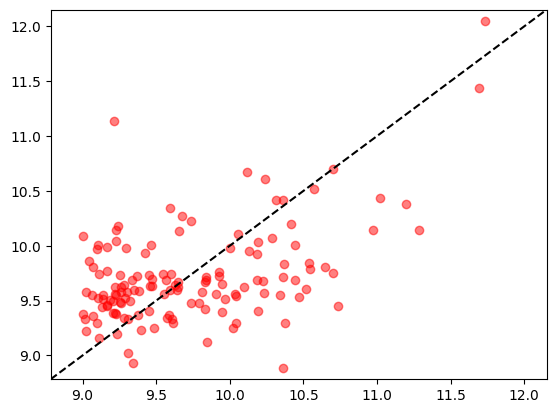

In [134]:
plt.plot(ys[:,0].detach().numpy(), outs[:,0].detach().numpy(), 'ro', alpha = 0.5)
r = np.hstack([ys[:,0].detach().numpy(), outs[:,0].detach().numpy()])
r = [np.min(r)-.1, np.max(r)+0.1]
plt.plot(r,r, 'k--')
plt.xlim(r)
plt.ylim(r)
# plt.plot(datas[0].y.view(-1,n_targ)[:,0].detach().numpy(), out[:,0].detach().numpy(), 'ro')


In [130]:
r

[9.003032, 11.737026]

In [113]:
data[:7], data[-1:]

([Data(x=[136, 8], edge_index=[2, 1440], edge_attr=[1440, 3], y=[136, 2]),
  Data(x=[187, 8], edge_index=[2, 2354], edge_attr=[2354, 3], y=[187, 2]),
  Data(x=[185, 8], edge_index=[2, 2560], edge_attr=[2560, 3], y=[185, 2]),
  Data(x=[438, 8], edge_index=[2, 23388], edge_attr=[23388, 3], y=[438, 2]),
  Data(x=[411, 8], edge_index=[2, 17430], edge_attr=[17430, 3], y=[411, 2]),
  Data(x=[225, 8], edge_index=[2, 3320], edge_attr=[3320, 3], y=[225, 2]),
  Data(x=[264, 8], edge_index=[2, 3520], edge_attr=[3520, 3], y=[264, 2])],
 [Data(x=[154, 8], edge_index=[2, 1618], edge_attr=[1618, 3], y=[154, 2])])